# Setup

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import XLMRobertaForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, naive_bayes, pipeline
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
import random
from nltk.corpus import stopwords
from gensim.utils import tokenize as tk
from gensim.models import Doc2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from utils.functions import group_texts, coalition_lr, coalition_topic, subcode_trans, extract_code, clean_text, retrieve_vectors, d2v_reduct
from utils.functions import train_loop
from utils.models import TLRRPredict


In [2]:
torch.cuda.empty_cache() 
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [3]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

# Implementation

### Data preparation

In [4]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8")

In [5]:
manifesto = manifesto[(manifesto.code.notna()) & ~(manifesto.code == 'H')].reset_index(drop=True)

In [6]:
manifesto['code_long'] = manifesto['code'].apply(subcode_trans)
manifesto['code_extract'] = manifesto['code_long'].astype(str).apply(extract_code)



In [7]:
manifesto['lrn'] = manifesto.apply(lambda x: coalition_lr(x['code_long'], x['code_extract']), axis=1)
manifesto['topic'] = manifesto['code_extract'].apply(coalition_topic)

In [8]:
manifesto.groupby('lrn').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,topic
lrn,,,,,,,,,,,,,
left,472559,472559,472559,472559,472559,472559,472559,472559,472559,472559,472559,472559,472559
neutral,264559,264559,264559,264559,264559,264559,264559,264559,264559,264559,264559,264559,264559
right,106204,106204,106204,106204,106204,106204,106204,106204,106204,106204,106204,106204,106204


In [9]:
manifesto.groupby('topic').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn
topic,,,,,,,,,,,,,
Agriculture,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495
Civil Rights,121225,121225,121225,121225,121225,121225,121225,121225,121225,121225,121225,121225,121225
Decentralization,26640,26640,26640,26640,26640,26640,26640,26640,26640,26640,26640,26640,26640
Defense,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392
Economy,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409
Education,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364
Environment,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961
European integration,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567
Immigration,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729


In [10]:
len(manifesto[manifesto.lrn=="right"])/len(manifesto)*100 ## minority group: 12.5%

12.593528924894642

In [11]:
len(manifesto[manifesto.topic=="Defense"])/len(manifesto)*100 ## minority group: 1.7%

1.7065841991552457

In [12]:
texts = manifesto['text'].tolist()

In [13]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 17.97537002473551
Std length (word) is: 11.163519592598034
Min length (word) is: 1
Max length (word) is: 269


<Axes: >

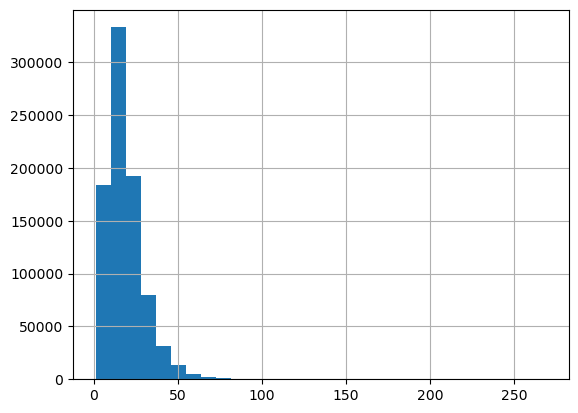

In [14]:
pd.Series(seq_len).hist(bins = 30)

In [22]:
results = group_texts(manifesto, ['countryname','election','party','code_long'],'text', group_factor = 4)

Length of ('Austria', 1999, 42110, '10400') is: 2
Length of ('Austria', 1999, 42110, '10500') is: 23
Length of ('Austria', 1999, 42110, '10600') is: 6
Length of ('Austria', 1999, 42110, '10700') is: 63
Length of ('Austria', 1999, 42110, '10800') is: 21
Length of ('Austria', 1999, 42110, '10900') is: 37
Length of ('Austria', 1999, 42110, '11000') is: 1
Length of ('Austria', 1999, 42110, '20100') is: 53
Length of ('Austria', 1999, 42110, '20200') is: 23
Length of ('Austria', 1999, 42110, '30100') is: 1
Length of ('Austria', 1999, 42110, '30300') is: 5
Length of ('Austria', 1999, 42110, '30500') is: 54
Length of ('Austria', 1999, 42110, '40100') is: 8
Length of ('Austria', 1999, 42110, '40300') is: 5
Length of ('Austria', 1999, 42110, '40800') is: 2
Length of ('Austria', 1999, 42110, '41100') is: 31
Length of ('Austria', 1999, 42110, '41200') is: 17
Length of ('Austria', 1999, 42110, '41600') is: 12
Length of ('Austria', 1999, 42110, '50100') is: 86
Length of ('Austria', 1999, 42110, '502

In [23]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [24]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)

In [25]:
manifesto_regrouped.head()

,text,labels,0,1,2,3
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500
2,Sicherheitspolitik ist viel mehr als Militärpo...,Austria_1999_42110_10500,Austria,1999,42110,10500
3,und nukleare Erstschlagskapazität Teil der NAT...,Austria_1999_42110_10500,Austria,1999,42110,10500
4,Abrüsten auch in Österreich: Die allgemeine We...,Austria_1999_42110_10500,Austria,1999,42110,10500


In [26]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'code_long']

In [27]:
manifesto_regrouped['code_extract'] = manifesto_regrouped['code_long'].apply(extract_code)
manifesto_regrouped['lrn'] = manifesto_regrouped.apply(lambda x: coalition_lr(x['code_long'], x['code_extract']), axis=1)
manifesto_regrouped['topic'] = manifesto_regrouped['code_extract'].apply(coalition_topic)


In [28]:
manifesto_regrouped.groupby('lrn').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,topic
lrn,,,,,,,,
left,123227,123227,123227,123227,123227,123227,123227,123227
neutral,69284,69284,69284,69284,69284,69284,69284,69284
right,28929,28929,28929,28929,28929,28929,28929,28929


In [29]:
texts = manifesto_regrouped['text'].tolist()
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 68.45657966040463
Std length (word) is: 32.03554468879466
Min length (word) is: 1
Max length (word) is: 363


<Axes: >

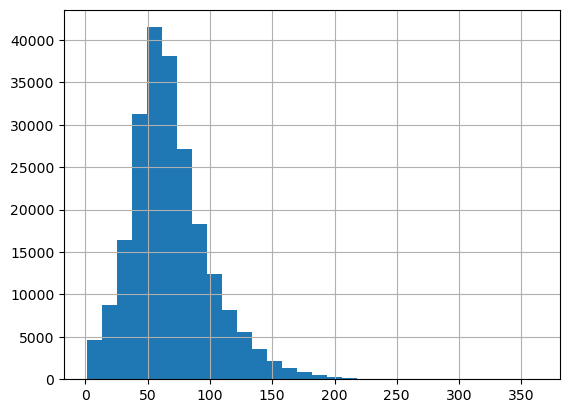

In [30]:
pd.Series(seq_len).hist(bins = 30)

In [31]:
manifesto_regrouped.to_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8', index=False)
manifesto.to_csv('data/temps/manifesto.csv', encoding='utf-8', index=False)

### Fine-tuning with CMP's original categorization scheme

In [61]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

In [32]:
manifesto_regrouped.groupby('lrn').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,topic
lrn,,,,,,,,
left,123227,123227,123227,123227,123227,123227,123227,123227
neutral,69284,69284,69284,69284,69284,69284,69284,69284
right,28929,28929,28929,28929,28929,28929,28929,28929


In [33]:
manifesto_regrouped.groupby('topic').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn
topic,,,,,,,,
Agriculture,5633,5633,5633,5633,5633,5633,5633,5633
Civil Rights,32020,32020,32020,32020,32020,32020,32020,32020
Decentralization,7003,7003,7003,7003,7003,7003,7003,7003
Defense,3944,3944,3944,3944,3944,3944,3944,3944
Economy,23044,23044,23044,23044,23044,23044,23044,23044
Education,11146,11146,11146,11146,11146,11146,11146,11146
Environment,23720,23720,23720,23720,23720,23720,23720,23720
European integration,5270,5270,5270,5270,5270,5270,5270,5270
Immigration,8019,8019,8019,8019,8019,8019,8019,8019


In [34]:
manifesto_reduced = manifesto_regrouped[['topic','lrn','text']].reset_index(drop=True)

In [35]:
manifesto_reduced['topic_lrn'] = manifesto_reduced['topic'] + '_' + manifesto_reduced['lrn']

In [36]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [37]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('topic_lrn')



Casting to class labels:   0%|          | 0/221440 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/221440 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/221440 [00:00<?, ? examples/s]

In [38]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='topic_lrn', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='topic_lrn', seed=seed_val )

In [39]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['topic', 'lrn', 'text', 'topic_lrn'],
        num_rows: 139507
    })
    test: Dataset({
        features: ['topic', 'lrn', 'text', 'topic_lrn'],
        num_rows: 22144
    })
    eval: Dataset({
        features: ['topic', 'lrn', 'text', 'topic_lrn'],
        num_rows: 59789
    })
})

In [40]:
train_set = manifesto_datasets['train'].to_pandas()
train_set.groupby('lrn').count()

,topic,text,topic_lrn
lrn,,,
0,77633,77633,77633
1,43649,43649,43649
2,18225,18225,18225


In [41]:
from sklearn.utils.class_weight import compute_class_weight

In [42]:
cw_lr = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.lrn), y=train_set.lrn)
cw_lr

array([0.59900214, 1.06536996, 2.55156836])

In [44]:
cw_lr = np.array([0.6, 1.1, 3.5])

In [45]:
cw_topic = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.topic), y=train_set.topic)
cw_topic

array([3.27665821, 0.57629422, 2.63499169, 4.68018653, 0.80077031,
       1.65535858, 0.77799527, 3.50168173, 2.30118435, 2.20390205,
       0.32942996, 0.49535913])

In [46]:
def tokenize_function(dataset, tokenizer, text_var, max_length):
    return tokenizer(dataset[text_var], truncation=True, max_length=max_length)

In [47]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 350}, 
                                            remove_columns=['text','topic_lrn'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/139507 [00:00<?, ? examples/s]

Map:   0%|          | 0/22144 [00:00<?, ? examples/s]

Map:   0%|          | 0/59789 [00:00<?, ? examples/s]

['topic', 'lrn', 'input_ids', 'attention_mask']

In [48]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=16, shuffle=False, collate_fn = data_collator)

In [49]:
from transformers.modeling_utils import PreTrainedModel, PretrainedConfig
from transformers import XLMRobertaConfig

In [50]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [66]:
config

PretrainedConfig {
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "transformers_version": "4.34.0",
  "vocab_size": 250002
}

In [51]:
from transformers import XLMRobertaModel


In [52]:
class TLRRPredict(PreTrainedModel):
    def __init__(self, config, roberta_model, topic_count, lr_count, hidden_dim, hidden_dim_2, roberta_dim,dropout=0.1):
        super(TLRRPredict, self).__init__(config)
        self.roberta = XLMRobertaModel.from_pretrained(roberta_model) ## get information from a pre-trained model
        self.mlp1 = nn.Sequential(
            nn.Linear(config.hidden_size, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, topic_count)
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(topic_count, hidden_dim_2),
            nn.LayerNorm(hidden_dim_2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim_2, hidden_dim_2),
            nn.LayerNorm(hidden_dim_2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim_2, lr_count)
        )

        self.decoder = nn.Sequential(
            nn.Linear(lr_count, hidden_dim_2),
            nn.LayerNorm(hidden_dim_2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim_2, topic_count),
            nn.LayerNorm(topic_count),
            nn.Dropout(dropout),
            nn.Linear(topic_count, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, roberta_dim)
        )

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)['pooler_output'] 
        logits_topic = self.mlp1(roberta_output)
        logits_lr = self.mlp2(logits_topic)
        logits_reconstruct = self.decoder(logits_lr)
        return logits_topic, logits_lr, logits_reconstruct, roberta_output





In [53]:
topic_count = len(set(manifesto_regrouped['topic']))
lr_count = len(set(manifesto_regrouped['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count, 
                    hidden_dim=int(config.hidden_size/2), hidden_dim_2=int(topic_count/2),
                    roberta_dim=768).to(device)


In [54]:
from transformers import get_linear_schedule_with_warmup
n_epochs=4
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
loss_fn_topic = nn.CrossEntropyLoss(weight= torch.tensor(cw_topic, device=device).type(torch.float32))
loss_fn_lr = nn.CrossEntropyLoss(weight= torch.tensor(cw_lr, device=device).type(torch.float32))
loss_fn_reconstruct = nn.MSELoss()

In [55]:
import time
import datetime
def format_time(elapsed):

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [56]:
next(iter(train_dataloader))

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'topic': tensor([10,  8,  8,  2, 10,  1, 10,  4,  4, 10,  4,  7,  6,  6,  8,  1]), 'lrn': tensor([1, 2, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 1]), 'input_ids': tensor([[     0,   8892,    262,  ...,      1,      1,      1],
        [     0,    622, 188585,  ...,      1,      1,      1],
        [     0,    768,    159,  ...,      1,      1,      1],
        ...,
        [     0,    582,   3434,  ...,      1,      1,      1],
        [     0,   6646,   5359,  ...,      1,      1,      1],
        [     0,  64079,  42285,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [57]:
def train_loop(dataloader, model, optimizer, scheduler, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device):
    print("")
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Put the model into training mode. 
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    # For each batch of training data...optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    for batch_num, batch in enumerate(dataloader):
      batch = {k: v.to(device) for k,v in batch.items()}
      optimizer.zero_grad()
      y_topic = batch['topic'].long()
      y_lr = batch['lrn'].long()
      logits_topic, logits_lr, logits_reconstruct, roberta_output = model(input_ids = batch['input_ids'], 
                                      attention_mask = batch['attention_mask'])
      loss_topic = loss_fn_topic(logits_topic, y_topic)
      loss_lr = loss_fn_lr(logits_lr, y_lr)
      loss_reconstruct = loss_fn_reconstruct(logits_reconstruct, roberta_output)
      loss = 0.3*loss_topic + 0.5*loss_lr + 0.2*loss_reconstruct
      # Backpropagation
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step()
      train_loss += loss.item()
      # Report
      if batch_num % 1000 == 0 and batch_num != 0:
        elapsed = format_time(time.time() - t0)
        current_loss = train_loss/batch_num
        current = batch_num * len(batch['input_ids'])
        print(f"loss: {current_loss:>7f}  [{current:>5d}/{size:>5d}]. Took {elapsed}")
    

  
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Training epoch took: {:}".format(training_time))

In [58]:
def eval_loop(dataloader, model, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct,device):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct_topic, correct_sent = 0.0, 0.0, 0.0
  model.eval()
  with torch.no_grad():  
    for batch in dataloader:    
        batch = {k: v.to(device) for k,v in batch.items()}
        y_topic = batch['topic'].long()
        y_lr = batch['lrn'].long()
        logits_topic, logits_lr, logits_reconstruct, roberta_output = model(input_ids = batch['input_ids'], 
                                      attention_mask = batch['attention_mask'])
        loss_topic = loss_fn_topic(logits_topic, y_topic)
        loss_lr = loss_fn_lr(logits_lr, y_lr)
        loss_reconstruct = loss_fn_reconstruct(logits_reconstruct, roberta_output)
        loss = 0.3*loss_topic + 0.5*loss_lr + 0.2*loss_reconstruct
        test_loss += loss
        correct_topic += (logits_topic.argmax(1) == batch['topic']).type(torch.float).sum().item()
        correct_sent += (logits_lr.argmax(1) == batch['lrn']).type(torch.float).sum().item()

  test_loss /= num_batches
  correct_topic /= size
  correct_sent /= size
  correct = (correct_topic+correct_sent)/2
  print(f"Test Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  print(f"Test Error: \n Accuracy - LR: {(correct_sent*100):>0.1f}, Avg loss: {test_loss:>8f} \n")
  print(f"Test Error: \n Accuracy - Topic: {(correct_topic*100):>0.1f}, Avg loss: {test_loss:>8f} \n")


In [60]:
eval_loop(eval_dataloader, model, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device)
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device)
    eval_loop(eval_dataloader, model, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device)
 
    

Test Error: 
 Accuracy: 33.4%, Avg loss: 1.462056 

Test Error: 
 Accuracy - LR: 55.6, Avg loss: 1.462056 

Test Error: 
 Accuracy - Topic: 11.2, Avg loss: 1.462056 

Epoch: 1

Training...


KeyError: 'lr'

In [151]:
model.save_pretrained('results/multilingual/manifesto_tlrr/')
tokenizer.save_pretrained('results/multilingual/manifesto_tlrr/')

('results/multilingual/manifesto_tlrr/tokenizer_config.json',
 'results/multilingual/manifesto_tlrr/special_tokens_map.json',
 'results/multilingual/manifesto_tlrr/sentencepiece.bpe.model',
 'results/multilingual/manifesto_tlrr/added_tokens.json',
 'results/multilingual/manifesto_tlrr/tokenizer.json')

In [105]:
def test_func(dataloader, model):
  model.eval()
  res_topic = []
  res_lr = []
  with torch.no_grad():  
    for batch in dataloader:    
        batch = {k: v.to(device) for k,v in batch.items()}
        logits_topic, logits_lr = model(input_ids = batch['input_ids'], 
                                        attention_mask = batch['attention_mask'])
        pred_topic = logits_topic.argmax(1)
        pred_lr = logits_lr.argmax(1)
        res_topic.append(pred_topic)
        res_lr.append(pred_lr)
  return res_topic, res_lr

In [106]:
pred_topics, pred_sent = test_func(test_dataloader, model)

In [107]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_sent = np.concatenate([i.cpu().detach().numpy() for i in pred_sent])

In [108]:
test_set = manifesto_datasets['test'].to_pandas()

In [109]:
labels = test_set['topic'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_topics, average=None)
matrix = confusion_matrix(labels, predicted_topics)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [110]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.76,0.72,0.81,0.81
1,0.77,0.77,0.76,0.76
2,0.76,0.69,0.83,0.83
3,0.85,0.81,0.90,0.90
4,0.72,0.70,0.75,0.75
5,0.83,0.78,0.90,0.90
6,0.83,0.82,0.84,0.84
7,0.78,0.73,0.84,0.84
8,0.68,0.62,0.74,0.74
9,0.78,0.78,0.80,0.80


In [111]:
round(res_table.mean(axis=0),2)

f1           0.77
precision    0.75
recall       0.80
accuracy     0.80
dtype: float64

In [112]:
list_names = manifesto_datasets['train'].features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [113]:
res_table['topic_name'] = pd.Series(res_table.index.values).map(name_topic_dict)

In [114]:
res_table

,f1,precision,recall,accuracy,topic_name
0,0.76,0.72,0.81,0.81,Agriculture
1,0.77,0.77,0.76,0.76,Civil Rights
2,0.76,0.69,0.83,0.83,Decentralization
3,0.85,0.81,0.90,0.90,Defense
4,0.72,0.70,0.75,0.75,Economy
5,0.83,0.78,0.90,0.90,Education
6,0.83,0.82,0.84,0.84,Environment
7,0.78,0.73,0.84,0.84,European integration
8,0.68,0.62,0.74,0.74,Immigration
9,0.78,0.78,0.80,0.80,International politics


In [115]:
labels = test_set['lrn'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_sent, average=None)
matrix = confusion_matrix(labels, predicted_sent)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [116]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.86,0.88,0.83,0.83
1,0.80,0.78,0.81,0.81
2,0.67,0.62,0.73,0.73


In [117]:
round(res_table.mean(axis=0),2)

f1           0.78
precision    0.76
recall       0.79
accuracy     0.79
dtype: float64

In [118]:
list_names = manifesto_datasets['train'].features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [119]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,lrn
0,0.86,0.88,0.83,0.83,left
1,0.80,0.78,0.81,0.81,neutral
2,0.67,0.62,0.73,0.73,right


### Fine-tuning with COALITIONAGREE's categorization scheme

#### Own test set

In [42]:
from utils.functions import coalition_lr, coalition_topic

In [43]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')
coalitionagree = pd.read_csv('data/r_outputs/coalitionagree_texts.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [44]:
manifesto_regrouped['coalition_lr'] = manifesto_regrouped.apply(lambda x: coalition_lr(x['code_cformat'], x['code_extract']), axis=1)

In [45]:
manifesto_regrouped.groupby('coalition_lr').count()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn
coalition_lr,,,,,,,,
left,123227,123227,123227,123227,123227,123227,123227,123227
neutral,69284,69284,69284,69284,69284,69284,69284,69284
right,28929,28929,28929,28929,28929,28929,28929,28929


In [46]:
manifesto_reduced = manifesto_regrouped[['coalition_lr','text']].reset_index(drop=True)

In [47]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [48]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('coalition_lr')
manifesto_dataset = manifesto_dataset.rename_column('coalition_lr','labels')



Casting to class labels:   0%|          | 0/221440 [00:00<?, ? examples/s]

In [49]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.25, stratify_by_column='labels', seed=seed_val )

In [50]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 149472
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 22144
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 49824
    })
})

In [51]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [52]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/149472 [00:00<?, ? examples/s]

Map:   0%|          | 0/22144 [00:00<?, ? examples/s]

Map:   0%|          | 0/49824 [00:00<?, ? examples/s]

['labels', 'input_ids', 'attention_mask']

In [53]:
num_classes = len(set(manifesto_regrouped['coalition_lr']))
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [55]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_coalitionlr",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

In [56]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }


In [57]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [58]:
trainer.train()

  0%|          | 0/14013 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6982, 'learning_rate': 1.8007564404481555e-05, 'epoch': 0.3}
{'loss': 0.5568, 'learning_rate': 1.6007992578320132e-05, 'epoch': 0.6}
{'loss': 0.5129, 'learning_rate': 1.4009847998287305e-05, 'epoch': 0.9}


  0%|          | 0/1557 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8468269802933249, 0.7717675692120475, 0.7263485477178423]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8725744788285363, 0.8136506511001347, 0.5378706406514058]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8595079491961986, 0.7921558830876843, 0.6180598464118634]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8725744788285363, 0.8136506511001347, 0.5378706406514058]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect s

{'eval_loss': 0.48302340507507324, 'eval_precision': [0.8468269802933249, 0.7717675692120475, 0.7263485477178423], 'eval_recall': [0.8725744788285363, 0.8136506511001347, 0.5378706406514058], 'eval_f1': [0.8595079491961986, 0.7921558830876843, 0.6180598464118634], 'eval_accuracy': [0.8725744788285363, 0.8136506511001347, 0.5378706406514058], 'eval_runtime': 79.3299, 'eval_samples_per_second': 628.06, 'eval_steps_per_second': 19.627, 'epoch': 1.0}
{'loss': 0.4515, 'learning_rate': 1.2010276172125884e-05, 'epoch': 1.2}
{'loss': 0.4241, 'learning_rate': 1.0013558838221653e-05, 'epoch': 1.5}
{'loss': 0.4085, 'learning_rate': 8.015414258188825e-06, 'epoch': 1.8}


  0%|          | 0/1557 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8546282874301098, 0.83837890625, 0.6816088424930918]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.893096732309024, 0.7709923664122137, 0.682132432017207]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8734391534391533, 0.8032748538011696, 0.681870536742686]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.893096732309024, 0.7709923664122137, 0.682132432017207]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropp

{'eval_loss': 0.463229775428772, 'eval_precision': [0.8546282874301098, 0.83837890625, 0.6816088424930918], 'eval_recall': [0.893096732309024, 0.7709923664122137, 0.682132432017207], 'eval_f1': [0.8734391534391533, 0.8032748538011696, 0.681870536742686], 'eval_accuracy': [0.893096732309024, 0.7709923664122137, 0.682132432017207], 'eval_runtime': 79.331, 'eval_samples_per_second': 628.052, 'eval_steps_per_second': 19.627, 'epoch': 2.0}
{'loss': 0.3779, 'learning_rate': 6.015842432027403e-06, 'epoch': 2.1}
{'loss': 0.3272, 'learning_rate': 4.016270605865982e-06, 'epoch': 2.4}
{'loss': 0.3229, 'learning_rate': 2.0166987797045603e-06, 'epoch': 2.7}
{'loss': 0.3144, 'learning_rate': 1.7126953543138516e-08, 'epoch': 3.0}


  0%|          | 0/1557 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8668630652374529, 0.8115075538412087, 0.7178014766201805]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8808699415710886, 0.8097376355122201, 0.672146259025964]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8738103756708407, 0.8106216285640894, 0.694224055855284]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8808699415710886, 0.8097376355122201, 0.672146259025964]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so w

{'eval_loss': 0.46465402841567993, 'eval_precision': [0.8668630652374529, 0.8115075538412087, 0.7178014766201805], 'eval_recall': [0.8808699415710886, 0.8097376355122201, 0.672146259025964], 'eval_f1': [0.8738103756708407, 0.8106216285640894, 0.694224055855284], 'eval_accuracy': [0.8808699415710886, 0.8097376355122201, 0.672146259025964], 'eval_runtime': 79.3187, 'eval_samples_per_second': 628.15, 'eval_steps_per_second': 19.63, 'epoch': 3.0}
{'train_runtime': 2690.2406, 'train_samples_per_second': 166.682, 'train_steps_per_second': 5.209, 'train_loss': 0.43941516971669803, 'epoch': 3.0}


TrainOutput(global_step=14013, training_loss=0.43941516971669803, metrics={'train_runtime': 2690.2406, 'train_samples_per_second': 166.682, 'train_steps_per_second': 5.209, 'train_loss': 0.43941516971669803, 'epoch': 3.0})

In [59]:
## Testing on COALITIONAGREE data, never seen in training or evaluation
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

  0%|          | 0/692 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8539509536784741, 0.8343605546995377, 0.6753292986828052]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.89012415807839, 0.7816108545034642, 0.655720705150363]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8716624284806103, 0.8071247577880459, 0.6653805682216766]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.89012415807839, 0.7816108545034642, 0.655720705150363]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we d

0.7813892514967776


In [60]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.87,0.85,0.89,0.89
1,0.81,0.83,0.78,0.78
2,0.67,0.68,0.66,0.66


In [61]:
round(res_table.mean(axis=0),2)

f1           0.78
precision    0.79
recall       0.78
accuracy     0.78
dtype: float64

In [62]:
res_table.to_csv('results/tabs and figs/coalitionlr_pred.csv', index=False)

#### COALITIONAGREE as test set

In [63]:
coalitionagree['coalition_lr'] = coalitionagree.apply(lambda x: coalition_lr(x['category3'], x['category2']), axis=1)

In [64]:
coalitionagree.groupby('coalition_lr').count()

,sentence,domain,category2,category3,level,id,country_init,cabinet_year,country
coalition_lr,,,,,,,,,
left,42773,42773,42773,42773,42773,42773,42773,42773,42773
neutral,41970,41970,41970,41970,41970,41970,41970,41970,41970
right,13367,13367,13367,13367,13367,13367,13367,13367,13367


In [65]:
results = group_texts(coalitionagree, ['country','cabinet_year','category3'], 'sentence',group_factor = 4)

Length of ('Austria', 1945, 30301) is: 2
Length of ('Austria', 1945, 30303) is: 1
Length of ('Austria', 1945, 30506) is: 1
Length of ('Austria', 1945, 41301) is: 1
Length of ('Austria', 1945, 50602) is: 2
Length of ('Austria', 1945, 80000) is: 1
Length of ('Austria', 1945, 90001) is: 5
Length of ('Austria', 1945, 90002) is: 17
Length of ('Austria', 1945, 90004) is: 1
Length of ('Austria', 1945, 90006) is: 1
Length of ('Austria', 1949, 10401) is: 2
Length of ('Austria', 1949, 30301) is: 1
Length of ('Austria', 1949, 40601) is: 7
Length of ('Austria', 1949, 41202) is: 2
Length of ('Austria', 1949, 41301) is: 9
Length of ('Austria', 1949, 41304) is: 3
Length of ('Austria', 1949, 50602) is: 1
Length of ('Austria', 1949, 50603) is: 1
Length of ('Austria', 1949, 60701) is: 3
Length of ('Austria', 1949, 70604) is: 1
Length of ('Austria', 1949, 80000) is: 4
Length of ('Austria', 1949, 90001) is: 14
Length of ('Austria', 1949, 90002) is: 45
Length of ('Austria', 1949, 90006) is: 1
Length of ('A

In [66]:
coalition_regrouped = pd.DataFrame(results)
coalition_regrouped = coalition_regrouped.explode('text').reset_index(drop=True)
df_cols = coalition_regrouped['labels'].str.split('_', expand=True)
coalition_regrouped = pd.concat([coalition_regrouped, df_cols], axis=1)
coalition_regrouped.columns =['text','labels', 'country','year', 'code']
coalition_regrouped['code_short'] = coalition_regrouped['code'].apply(extract_code)

In [67]:
coalition_regrouped.head()

,text,labels,country,year,code,code_short
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506


In [68]:
coalition_regrouped['coalition_lr'] = coalition_regrouped.apply(lambda x: coalition_lr(x['code'], x['code_short']), axis=1)

In [69]:
coalition_regrouped.groupby('coalition_lr').count()

,text,labels,country,year,code,code_short
coalition_lr,,,,,,
left,12850,12850,12850,12850,12850,12850
neutral,12010,12010,12010,12010,12010,12010
right,4196,4196,4196,4196,4196,4196


In [70]:
cagree_reduced = coalition_regrouped[['coalition_lr', 'text']]

In [71]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('coalition_lr')
cagree_dataset = cagree_dataset.rename_column('coalition_lr','labels')


Casting to class labels:   0%|          | 0/29056 [00:00<?, ? examples/s]

In [72]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': cagree_dataset,
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 149472
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 29056
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 49824
    })
})

In [73]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [74]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/149472 [00:00<?, ? examples/s]

Map:   0%|          | 0/29056 [00:00<?, ? examples/s]

Map:   0%|          | 0/49824 [00:00<?, ? examples/s]

['labels', 'input_ids', 'attention_mask']

In [75]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [76]:
## Get predictions
preds = trainer.predict(tokenized_datasets['test'])

  0%|          | 0/908 [00:00<?, ?it/s]

In [77]:
res_table = pd.DataFrame({'f1': np.round(preds[2]['test_f1'],2), 'precision': np.round(preds[2]['test_precision'],2), 
'recall': np.round(preds[2]['test_recall'],2), 'accuracy': np.round(preds[2]['test_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.77,0.74,0.81,0.81
1,0.73,0.80,0.67,0.67
2,0.59,0.54,0.65,0.65


In [78]:
## Save predictions
coalition_regrouped['preds'] = preds[0].argmax(1)

In [79]:
coalition_regrouped.to_csv('data/py_outputs/coalition_pred.csv', encoding='utf-8', index=False)

### Example 1: Germany - CMP code

#### Some more pre-processing

In [213]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)
## Load pre-trained models
model = TLRRPredict(config, model_name, topic_count, lr_count, hidden_dim=int(config.hidden_size/2), hidden_dim_2=int(topic_count/2),
                    roberta_dim=768).to(device)
model.load_state_dict(torch.load('results/multilingual/manifesto_tlrr/pytorch_model.bin'))

<All keys matched successfully>

In [171]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')

In [172]:
manifesto_deu = manifesto[manifesto.countryname == 'Germany'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped.country == 'Germany'].reset_index(drop=True)

In [175]:
manifesto_deu_rgr.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other
1,Aber die Angst vor einer Veränderung ist auch ...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other
2,Das ist die eine Seite Aber nicht alles – eins...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other
3,Die im Vergleich zu den bisherigen Ausgaben an...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other
4,Die Immunitätsregelung für Eurocops ist aufzuh...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other


In [176]:
manifesto_deu.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic,lrn_coalition
0,Es ist Zeit für einen Wechsel,1998,0.0,26,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other,neutral
1,"Die Bundesrepublik braucht eine neue, eine soz...",1998,303.0,27,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,30300,303,neutral,Other,neutral
2,Die Herausforderungen eines neuen Jahrhunderts...,1998,303.0,28,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,30300,303,neutral,Other,neutral
3,Politik kann nicht alle Probleme lösen,1998,0.0,29,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other,neutral
4,Aber Politik muß ihren Teil zur Lösung der Pro...,1998,0.0,30,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other,neutral


In [177]:
lr_kws = dict({'left': 'left', 'right': 'right'})

In [178]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lrn')

#### Scaling with Supervised UMAP

In [215]:
def scale_func(dataloader, model):
  model.eval()
  res_topic = []
  res_lr_score = []
  with torch.no_grad():  
    for batch in dataloader:    
        batch = {k: v.to(device) for k,v in batch.items()}
        logits_topic, logits_lr,_,_ = model(input_ids = batch['input_ids'], 
                                        attention_mask = batch['attention_mask'])
        pred_topic = logits_topic.argmax(1)
        lr_softmax = logits_lr.softmax(1)
        lr_score = torch.sum(torch.tensor([-1,0,1]).to(device)*lr_softmax, dim=1)
        res_topic.append(pred_topic)
        res_lr_score.append(lr_score)
  return res_topic, res_lr_score

In [209]:
manifesto_reduced = manifesto_deu_rgr[['topic','lrn','text']].reset_index(drop=True)

In [210]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')



Casting to class labels:   0%|          | 0/21262 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/21262 [00:00<?, ? examples/s]

In [211]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, remove_columns=['text'])
tokenized_dataset.set_format("torch")

Map:   0%|          | 0/21262 [00:00<?, ? examples/s]

In [212]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)

In [216]:
pred_topics, lr_score = scale_func(full_dataloader, model)

In [224]:
test = [i.cpu().detach().numpy() for i in lr_score]

In [228]:
scores = np.concatenate([i.cpu().detach().numpy() for i in lr_score])

In [229]:
manifesto_deu_rgr['lr_score'] = scores

In [230]:
manifesto_deu_rgr.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,lr_score
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,-0.039131
1,Aber die Angst vor einer Veränderung ist auch ...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,-0.104761
2,Das ist die eine Seite Aber nicht alles – eins...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,0.750551
3,Die im Vergleich zu den bisherigen Ausgaben an...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,-0.043889
4,Die Immunitätsregelung für Eurocops ist aufzuh...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,-0.048639


In [232]:
columns  =['party', 'election','mean_score', 'se_score']
df = pd.DataFrame(columns=columns)

for name, group in manifesto_deu_rgr.groupby(['party','election']):
    mean_score = group['lr_score'].mean()
    se_score = group['lr_score'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_score, se_score]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)

In [233]:
df

,party,election,mean_score,se_score
0,41113,1998,-0.391360,0.020182
1,41113,2002,-0.445073,0.021857
2,41113,2005,-0.434140,0.020288
3,41113,2009,-0.469494,0.014443
4,41113,2013,-0.466642,0.011911
5,41113,2017,-0.498756,0.013231
6,41113,2021,-0.457966,0.013836
7,41221,1998,-0.442936,0.024985
8,41221,2002,-0.397516,0.029686
9,41222,2005,-0.364746,0.038896


In [8]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_lrn/checkpoint-9342'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_lrn/checkpoint-9342 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
scaled_results = scale_umap(manifesto_deu_rgr, model, text_var='text', guide_var='lrn', guidance_weight=0.5, n_components=2, random_state=seed_val, metric='cosine', 
                            n_jobs=1)

The shape of this document embeddings is: (21262, 768)


In [13]:
## Silhouette score, calculate by each country because scores were scaled by each country
umap_reduced = np.array(scaled_results[0][['umap_d1', 'umap_d2']])
y = np.array(scaled_results[0]['y'])
umap_silscore = silhouette_score(embeds_reduced, y, random_state=seed_val)
umap_silscore

0.7878439

In [127]:
document_embed = np.vstack(scaled_results[1])


In [128]:
document_embed = np.vstack(scaled_results[1])
umap_trust = trustworthiness(document_embed, embeds_reduced)
umap_trust

0.9830968136076984

In [14]:
columns  =['party', 'election','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [234]:
df['lr_log'] = logscale

In [235]:
np.corrcoef(df['lr_log'], df['mean_score'])

array([[1.        , 0.96028344],
       [0.96028344, 1.        ]])

In [132]:
df.to_csv("results/arrays/tf_gen.csv", index=False)

In [260]:
cat_counts = list(manifesto_deu_rgr.groupby('lrn').count()['text'])
imba_gen = round(min(cat_counts)/max(cat_counts),2)

In [133]:
np.savetxt('results/arrays/umap_embed_normal.csv', document_embed)


### Scale by confrontational topics

In [21]:
from utils.functions import lowe_lr, lowe_topic
from scipy.stats import entropy

In [22]:
manifesto_deu['lowe_lr'] = manifesto_deu['code_extract'].apply(lowe_lr)
manifesto_deu_rgr['lowe_lr'] = manifesto_deu_rgr['code_extract'].apply(lowe_lr)
manifesto_deu['lowe_topic'] = manifesto_deu['code_extract'].apply(lowe_topic)
manifesto_deu_rgr['lowe_topic'] = manifesto_deu_rgr['code_extract'].apply(lowe_topic)


In [84]:
manifesto_deu['coalition_lr'] = manifesto_deu.apply(lambda x: coalition_lr(x['code_cformat'], x['code_extract']), axis=1)
manifesto_deu['coalition_topic'] = manifesto_deu['code_extract'].apply(coalition_topic)

In [85]:
## Coalition dataset coding
manifesto_deu.to_csv('data/py_outputs/manifesto_deu.csv', encoding='utf-8', index=False)


In [86]:
manifesto_deu.groupby(['coalition_topic', 'coalition_lr']).count()

text  election   code    pos  \
coalition_topic        coalition_lr                                  
Agriculture            left             98        98     98     98   
                       neutral         820       820    820    820   
                       right           176       176    176    176   
Civil Rights           left          10273     10273  10273  10273   
                       neutral        2473      2473   2473   2473   
                       right           918       918    918    918   
Decentralization       left           1199      1199   1199   1199   
                       right           253       253    253    253   
Defense                left           1001      1001   1001   1001   
                       right           706       706    706    706   
Economy                left           6054      6054   6054   6054   
                       right          3957      3957   3957   3957   
Education              left           3111      3111   3111   3111   
                       right            41        41     41     41   
Environment            left           6680      6680   6680   6680   
                       right           663       663    663    663   
European integration   left           1970      1970   1970   1970   
                       right           449       449    449    449   
Immigration            left           1445      1445   1445   1445   
                       right          1261      1261   1261   1261   
International politics left           3790      3790   3790   3790   
                       right           145       145    145    145   
Other                  neutral       21017     21017  21017  21017   
Social Welfare         left          12933     12933  12933  12933   
                       right           437       437    437    437   

                                     party_code  country  party  countryname  \
coalition_topic        coalition_lr                                            
Agriculture            left                  98       98     98           98   
                       neutral              820      820    820          820   
                       right                176      176    176          176   
Civil Rights           left               10273    10273  10273        10273   
                       neutral             2473     2473   2473         2473   
                       right                918      918    918          918   
Decentralization       left                1199     1199   1199         1199   
                       right                253      253    253          253   
Defense                left                1001     1001   1001         1001   
                       right                706      706    706          706   
Economy                left                6054     6054   6054         6054   
                       right               3957     3957   3957         3957   
Education              left                3111     3111   3111         3111   
                       right                 41       41     41           41   
Environment            left                6680     6680   6680         6680   
                       right                663      663    663          663   
European integration   left                1970     1970   1970         1970   
                       right                449      449    449          449   
Immigration            left                1445     1445   1445         1445   
                       right               1261     1261   1261         1261   
International politics left                3790     3790   3790         3790   
                       right                145      145    145          145   
Other                  neutral            21017    21017  21017        21017   
Social Welfare         left               12933    12933  12933        12933   
                       right                437      437    437    

In [8]:
manifesto_deu.groupby(['lowe_topic', 'lowe_lr']).count()

text  election   code    pos  party_code  \
lowe_topic              lowe_lr                                               
constitutionalism       negative     42        42     42     42          42   
                        positive    158       158    158    158         158   
decentralisation        negative    253       253    253    253         253   
                        positive   1199      1199   1199   1199        1199   
education               negative     41        41     41     41          41   
                        positive   3111      3111   3111   3111        3111   
environment             negative    663       663    663    663         663   
                        positive   6680      6680   6680   6680        6680   
eu                      negative    449       449    449    449         449   
                        positive   1970      1970   1970   1970        1970   
freemarket              negative   5683      5683   5683   5683        5683   
                        positive   3025      3025   3025   3025        3025   
international relations negative    145       145    145    145         145   
                        positive   2967      2967   2967   2967        2967   
irrelevant              unknown   38101     38101  38101  38101       38101   
keynesian               negative    932       932    932    932         932   
                        positive    245       245    245    245         245   
labour groups           negative    120       120    120    120         120   
                        positive   4172      4172   4172   4172        4172   
military                negative   1001      1001   1001   1001        1001   
                        positive    706       706    706    706         706   
multiculturalism        negative    327       327    327    327         327   
                        positive    991       991    991    991         991   
protectionism           negative    176       176    176    176         176   
                        positive     98        98     98     98          98   
traditionalism          negative   1188      1188   1188   1188        1188   
                        positive   1852      1852   1852   1852        1852   
welfare                 negative    437       437    437    437         437   
                        positive   5138      5138   5138   5138        5138   

                                  country  party  countryname   name  \
lowe_topic              lowe_lr                                        
constitutionalism       negative       42     42           42     42   
                        positive      158    158          158    158   
decentralisation        negative      253    253          253    253   
                        positive     1199   1199         1199   1199   
education               negative       41     41           41     41   
                        positive     3111   3111         3111   3111   
environment             negative      663    663          663    663   
                        positive     6680   6680         6680   6680   
eu                      negative      449    449          449    449   
                        positive     1970   1970         1970   1970   
freemarket              negative     5683   5683         5683   5683   
                        positive     3025   3025         3025   3025   
international relations negative      145    145          145    145   
                        positive     2967   2967         2967   2967   
irrelevant              unknown     38101  38101        38101  38101   
keynesian               negative      932    932          932    932   
                        positive      245    245          245    245   
labour groups           negative      120    120          120    120   
                        positive     4172   4172         4172   4172   
military                negative     1001   1001         1001   1001   
 

In [9]:
manifesto_deu_rgr.groupby(['lowe_topic', 'lowe_lr']).count()

text  country_election_party_code  country  \
lowe_topic              lowe_lr                                                
constitutionalism       negative    15                           15       15   
                        positive    54                           54       54   
decentralisation        negative    79                           79       79   
                        positive   317                          317      317   
education               negative    14                           14       14   
                        positive   791                          791      791   
environment             negative   181                          181      181   
                        positive  1705                         1705     1705   
eu                      negative   128                          128      128   
                        positive   507                          507      507   
freemarket              negative  1466                         1466     1466   
                        positive   784                          784      784   
international relations negative    49                           49       49   
                        positive   768                          768      768   
irrelevant              unknown   9836                         9836     9836   
keynesian               negative   249                          249      249   
                        positive    69                           69       69   
labour groups           negative    37                           37       37   
                        positive  1057                         1057     1057   
military                negative   267                          267      267   
                        positive   190                          190      190   
multiculturalism        negative    94                           94       94   
                        positive   272                          272      272   
protectionism           negative    56                           56       56   
                        positive    35                           35       35   
traditionalism          negative   326                          326      326   
                        positive   495                          495      495   
welfare                 negative   122                          122      122   
                        positive  1299                         1299     1299   

                                  election  party  code_cformat  code_extract  \
lowe_topic              lowe_lr                                                 
constitutionalism       negative        15     15            15            15   
                        positive        54     54            54            54   
decentralisation        negative        79     79            79            79   
                        positive       317    317           317           317   
education               negative        14     14            14            14   
                        positive       791    791           791           791   
environment             negative       181    181           181           181   
                        positive      1705   1705          1705          1705   
eu                      negative       128    128           128           128   
                        positive       507    507           507           507   
freemarket              negative      1466   1466          1466          1466   
                        positive       784    784           784           784   
international relations negative        49     49            49            49   
                        positive       768    768           768           768   
irrelevant              unknown       9836   9836          9836          9836   
keynesian               negative       249    249           249           249   
                        positive        69     69            69            69   
labour groups 

#### Traditionalism

In [229]:
manifesto_deu_td = manifesto_deu[manifesto_deu.lowe_topic == 'traditionalism'].reset_index(drop=True)
manifesto_deu_rgr_td = manifesto_deu_rgr[manifesto_deu_rgr.lowe_topic == 'traditionalism'].reset_index(drop=True)

In [178]:
manifesto_deu_td.groupby('lowe_lr').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_cformat,code_extract,lrn,lowe_topic
lowe_lr,,,,,,,,,,,,,,
negative,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188
positive,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852


In [179]:
manifesto_deu_rgr_td.groupby('lowe_lr').count()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,umap_d1,umap_d2,y,lowe_topic
lowe_lr,,,,,,,,,,,,
negative,326,326,326,326,326,326,326,326,326,326,326,326
positive,495,495,495,495,495,495,495,495,495,495,495,495


In [180]:
scaled_results = scale_umap(manifesto_deu_rgr_td, model, text_var='text', guide_var='lowe_lr', guidance_weight=0.5, n_components=2, random_state=seed_val, metric='cosine', 
                            n_jobs=1)

The shape of this document embeddings is: (821, 768)


In [181]:
lr_kws = {'left': 'negative', 'right': 'positive'}

In [182]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu_td, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lowe_lr')

In [188]:
columns  =['party', 'election','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [189]:
df['lr_log'] = logscale
df['topic'] = 'traditionalism'

In [261]:
cat_counts = list(manifesto_deu_rgr_td.groupby('lowe_lr').count()['text'])
imba_td = round(min(cat_counts)/max(cat_counts),2)

In [191]:
np.corrcoef(df['lr_log'], df['cs_mean_d1'])

array([[1.        , 0.96837708],
       [0.96837708, 1.        ]])

In [190]:
df.to_csv("results/arrays/tf_td.csv", index=False)

#### Environment

In [231]:
manifesto_deu_env = manifesto_deu[manifesto_deu.lowe_topic == 'environment'].reset_index(drop=True)
manifesto_deu_rgr_env = manifesto_deu_rgr[manifesto_deu_rgr.lowe_topic == 'environment'].reset_index(drop=True)

In [193]:
manifesto_deu_env.groupby('lowe_lr').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_cformat,code_extract,lrn,lowe_topic
lowe_lr,,,,,,,,,,,,,,
negative,663,663,663,663,663,663,663,663,663,663,663,663,663,663
positive,6680,6680,6680,6680,6680,6680,6680,6680,6680,6680,6680,6680,6680,6680


In [177]:
manifesto_deu_rgr_env.groupby('lowe_lr').count()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,umap_d1,umap_d2,y,lowe_topic
lowe_lr,,,,,,,,,,,,
negative,181,181,181,181,181,181,181,181,181,181,181,181
positive,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705,1705


In [194]:
lr_kws = {'left': 'positive', 'right': 'negative'}

In [197]:
scaled_results = scale_umap(manifesto_deu_rgr_env, model, text_var='text', guide_var='lowe_lr', guidance_weight=0.5, n_components=2, random_state=seed_val, metric='cosine', 
                            n_jobs=1)

The shape of this document embeddings is: (1886, 768)


In [198]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu_env, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lowe_lr')

In [199]:
columns  =['party', 'election','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [200]:
df['lr_log'] = logscale
df['topic'] = 'environment'

In [262]:
cat_counts = list(manifesto_deu_rgr_env.groupby('lowe_lr').count()['text'])
imba_env = round(min(cat_counts)/max(cat_counts),2)

In [204]:
np.corrcoef(df['lr_log'], df['cs_mean_d2'])

array([[1.        , 0.77579211],
       [0.77579211, 1.        ]])

In [202]:
df.to_csv("results/arrays/tf_env.csv", index=False)

#### Free market

In [233]:
manifesto_deu_fm = manifesto_deu[manifesto_deu.lowe_topic == 'freemarket'].reset_index(drop=True)
manifesto_deu_rgr_fm = manifesto_deu_rgr[manifesto_deu_rgr.lowe_topic == 'freemarket'].reset_index(drop=True)

In [12]:
manifesto_deu_fm.groupby('lowe_lr').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_cformat,code_extract,lrn,lowe_topic
lowe_lr,,,,,,,,,,,,,,
negative,5683,5683,5683,5683,5683,5683,5683,5683,5683,5683,5683,5683,5683,5683
positive,3025,3025,3025,3025,3025,3025,3025,3025,3025,3025,3025,3025,3025,3025


In [13]:
manifesto_deu_rgr_fm.groupby('lowe_lr').count()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,lowe_topic
lowe_lr,,,,,,,,,
negative,1466,1466,1466,1466,1466,1466,1466,1466,1466
positive,784,784,784,784,784,784,784,784,784


In [14]:
lr_kws = {'left': 'negative', 'right': 'positive'}

In [17]:
scaled_results = scale_umap(manifesto_deu_rgr_fm, model, text_var='text', guide_var='lowe_lr', guidance_weight=0.5, n_components=2, random_state=seed_val, metric='cosine', 
                            n_jobs=1)

The shape of this document embeddings is: (2250, 768)


In [18]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu_fm, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lowe_lr')

In [19]:
columns  =['party', 'election','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [20]:
df['lr_log'] = logscale
df['topic'] = 'freemarket'

In [259]:
cat_counts = list(manifesto_deu_rgr_fm.groupby('lowe_lr').count()['text'])
imba_fm = round(min(cat_counts)/max(cat_counts),2)

In [21]:
np.corrcoef(df['lr_log'], df['cs_mean_d1'])

array([[ 1.       , -0.9555756],
       [-0.9555756,  1.       ]])

In [22]:
df.to_csv("results/arrays/tf_fm.csv", index=False)

#### Welfare

In [235]:
manifesto_deu_wf = manifesto_deu[manifesto_deu.lowe_topic == 'welfare'].reset_index(drop=True)
manifesto_deu_rgr_wf = manifesto_deu_rgr[manifesto_deu_rgr.lowe_topic == 'welfare'].reset_index(drop=True)

In [27]:
manifesto_deu_wf.groupby('lowe_lr').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_cformat,code_extract,lrn,lowe_topic
lowe_lr,,,,,,,,,,,,,,
negative,437,437,437,437,437,437,437,437,437,437,437,437,437,437
positive,5138,5138,5138,5138,5138,5138,5138,5138,5138,5138,5138,5138,5138,5138


In [39]:
manifesto_deu_rgr_wf.groupby('lowe_lr').count()['text'][0]

122

In [29]:
lr_kws = {'left': 'positive', 'right': 'negative'}

In [30]:
scaled_results = scale_umap(manifesto_deu_rgr_wf, model, text_var='text', guide_var='lowe_lr', guidance_weight=0.5, n_components=2, random_state=seed_val, metric='cosine', 
                            n_jobs=1)

The shape of this document embeddings is: (1421, 768)


In [31]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu_wf, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lowe_lr')

In [32]:
columns  =['party', 'election','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [33]:
df['lr_log'] = logscale
df['topic'] = 'welfare'b


In [87]:
np.corrcoef(df['lr_log'], df['cs_mean_d1'])

array([[ 1.       , -0.8369397],
       [-0.8369397,  1.       ]])

In [263]:
cat_counts = list(manifesto_deu_rgr_wf.groupby('lowe_lr').count()['text'])
imba_wf = round(min(cat_counts)/max(cat_counts),2)

In [80]:
df.to_csv("results/arrays/tf_wf.csv", index=False)

In [264]:
### Save Shannon entropy statistics

df_imba = pd.DataFrame({'imbalancedness': [imba_gen, imba_env, imba_fm, imba_td, imba_wf], 'topic': ['general', 'environment', 'freemarket', 'traditionalism', 'welfare']})

In [265]:
df_imba.to_csv('results/arrays/imba.csv')

### Confrontational vs non-confrontational

#### Environment protection: non-confrontational

In [99]:
manifesto_deu_envp = manifesto_deu[manifesto_deu.code_extract.isin([501])].reset_index(drop=True)
manifesto_deu_rgr_envp = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([501])].reset_index(drop=True)


In [100]:
manifesto_deu_rgr_envp.groupby(['lowe_lr']).count()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,lowe_topic
lowe_lr,,,,,,,,,
positive,1119,1119,1119,1119,1119,1119,1119,1119,1119


In [101]:
scaled_results = scale_umap(manifesto_deu_rgr_envp, model, text_var='text', guide_var='lowe_lr', guidance_weight=0.5, n_components=2, random_state=seed_val, 
                            metric='cosine', n_jobs=1)

The shape of this document embeddings is: (1119, 768)


In [102]:
lr_kws = {'left': 'positive', 'right': 'negative'}

In [103]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu_envp, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lowe_lr')

In [104]:
columns  =['party', 'election','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [105]:
df['lr_log'] = logscale
df['topic'] = 'environment protection'

In [106]:
np.corrcoef(df['lr_log'], df['cs_mean_d1'])

array([[1.        , 0.28466945],
       [0.28466945, 1.        ]])

In [107]:
df.to_csv('data/py_outputs/tf_envp.csv', encoding='utf-8', index=False)

#### Military: confrontational 

In [278]:
manifesto_deu_mil = manifesto_deu[manifesto_deu.code_extract.isin([104,105])].reset_index(drop=True)
manifesto_deu_rgr_mil = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([104,105])].reset_index(drop=True)

In [279]:
manifesto_deu_rgr_mil.groupby(['lowe_lr']).count()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,text_cleaned,lowe_topic,party_election
lowe_lr,,,,,,,,,,,
negative,267,267,267,267,267,267,267,267,267,267,267
positive,190,190,190,190,190,190,190,190,190,190,190


In [280]:
manifesto_deu_mil.groupby(['lowe_lr']).count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_cformat,code_extract,lrn,lowe_topic
lowe_lr,,,,,,,,,,,,,,
negative,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001
positive,706,706,706,706,706,706,706,706,706,706,706,706,706,706


In [281]:
scaled_results = scale_umap(manifesto_deu_rgr_mil, model, text_var='text', guide_var='lowe_lr', guidance_weight=0.5, n_components=2, random_state=seed_val, 
                            metric='cosine', n_jobs=1)

The shape of this document embeddings is: (457, 768)


In [282]:
lr_kws = {'left': 'negative', 'right': 'positive'}

In [283]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu_mil, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lowe_lr')

In [284]:
columns  =['party', 'election','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [285]:
df['lr_log'] = logscale
df['topic'] = 'military'

In [276]:
np.corrcoef(df['lr_log'], df['cs_mean_d1'])

array([[ 1.        , -0.97392219],
       [-0.97392219,  1.        ]])

In [286]:
df.to_csv('data/py_outputs/tf_mil.csv', encoding='utf-8', index=False)

### Extension: Scaling coalition agreements using a pre-trained model on manifesto data

In [302]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_coalitionlr/checkpoint-9342'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_coalitionlr/checkpoint-9342 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [303]:
coalition_pred = pd.read_csv('data/py_outputs/coalition_pred.csv', encoding='utf-8')

In [305]:
coalition_pred.groupby('preds').count()

,text,labels,country,year,code,code_short,coalition_lr,topic
preds,,,,,,,,
0,14005,14005,14005,14005,14005,14005,14005,11677
1,10033,10033,10033,10033,10033,10033,10033,3497
2,5018,5018,5018,5018,5018,5018,5018,3867


In [306]:
coalition_pred.groupby('coalition_lr').count()

,text,labels,country,year,code,code_short,preds,topic
coalition_lr,,,,,,,,
left,12850,12850,12850,12850,12850,12850,12850,12850
neutral,12010,12010,12010,12010,12010,12010,12010,1995
right,4196,4196,4196,4196,4196,4196,4196,4196


In [327]:
## ContextScale on predicted labels
scaled_results = scale_umap(coalition_pred, model, text_var='text', multi=True,scale_by_group = 'country',guide_var='preds', 
                            guidance_weight=0.5, n_components=2, random_state=seed_val, metric='cosine', n_jobs=1)

Start scaling parties in Austria
The shape of this document embeddings is: (3975, 768)
Start scaling parties in Belgium
The shape of this document embeddings is: (5201, 768)
Start scaling parties in Denmark
The shape of this document embeddings is: (2123, 768)
Start scaling parties in Finland
The shape of this document embeddings is: (3223, 768)
Start scaling parties in Germany
The shape of this document embeddings is: (4344, 768)
Start scaling parties in Greece
The shape of this document embeddings is: (167, 768)


c:\Users\Hung\anaconda3\envs\context_scale\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Start scaling parties in Iceland
The shape of this document embeddings is: (1342, 768)
Start scaling parties in Ireland
The shape of this document embeddings is: (2106, 768)
Start scaling parties in Netherlands
The shape of this document embeddings is: (3842, 768)
Start scaling parties in Norway
The shape of this document embeddings is: (1631, 768)
Start scaling parties in Portugal
The shape of this document embeddings is: (231, 768)


c:\Users\Hung\anaconda3\envs\context_scale\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Start scaling parties in Sweden
The shape of this document embeddings is: (871, 768)


In [328]:
columns  =['country', 'year','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['country','year']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]), 
                    str(group.iloc[0,group.columns.get_loc('year')]),
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [329]:
df.to_csv('data/py_outputs/coalition_preds_scaled.csv',encoding='utf-8', index=False)

In [322]:
## ContextScale on ground truth labels
scaled_results = scale_umap(coalition_pred, model, text_var='text', multi=True,scale_by_group = 'country',guide_var='coalition_lr', 
                            guidance_weight=0.5, n_components=2, random_state=seed_val, metric='cosine', n_jobs=1)

Start scaling parties in Austria
The shape of this document embeddings is: (3975, 768)
Start scaling parties in Belgium
The shape of this document embeddings is: (5201, 768)
Start scaling parties in Denmark
The shape of this document embeddings is: (2123, 768)
Start scaling parties in Finland
The shape of this document embeddings is: (3223, 768)
Start scaling parties in Germany
The shape of this document embeddings is: (4344, 768)
Start scaling parties in Greece
The shape of this document embeddings is: (167, 768)


c:\Users\Hung\anaconda3\envs\context_scale\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Start scaling parties in Iceland
The shape of this document embeddings is: (1342, 768)
Start scaling parties in Ireland
The shape of this document embeddings is: (2106, 768)
Start scaling parties in Netherlands
The shape of this document embeddings is: (3842, 768)
Start scaling parties in Norway
The shape of this document embeddings is: (1631, 768)
Start scaling parties in Portugal
The shape of this document embeddings is: (231, 768)


c:\Users\Hung\anaconda3\envs\context_scale\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Start scaling parties in Sweden
The shape of this document embeddings is: (871, 768)


In [325]:
columns  =['country', 'year','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['country','year']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]), 
                    str(group.iloc[0,group.columns.get_loc('year')]),
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


In [326]:
df.to_csv('data/py_outputs/coalition_gt_scaled.csv',encoding='utf-8', index=False)

## Scale by country with manifesto data

In [192]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

In [193]:
manifesto_regrouped.groupby('country').count()

,text,country_election_party_code,election,party,code_cformat,code_extract,lrn
country,,,,,,,
Austria,10600,10600,10600,10600,10600,10600,10600
Belgium,36476,36476,36476,36476,36476,36476,36476
Denmark,4637,4637,4637,4637,4637,4637,4637
Finland,5781,5781,5781,5781,5781,5781,5781
France,2366,2366,2366,2366,2366,2366,2366
Germany,21262,21262,21262,21262,21262,21262,21262
Greece,8665,8665,8665,8665,8665,8665,8665
Iceland,2773,2773,2773,2773,2773,2773,2773
Ireland,6711,6711,6711,6711,6711,6711,6711


In [194]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_lrn/checkpoint-9342'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_lrn/checkpoint-9342 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [196]:
scaled_results = scale_umap(manifesto_regrouped, model, text_var='text', scale_by_group= 'country', 
                            multi=True,guide_var='lrn', guidance_weight=0.5, n_components=2, random_state=seed_val, 
                            metric='cosine', n_jobs=1)

Start scaling parties in Austria
The shape of this document embeddings is: (10600, 768)
Start scaling parties in Belgium


In [ ]:
columns  =['country', 'party','election','cs_mean_d1', 'cs_mean_d2','cs_se_d1','cs_se_d2']
df = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['country','party', 'election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    se_d1 = group['umap_d1'].std()/np.sqrt(len(group))
    se_d2 = group['umap_d2'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]), 
                    str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]),
               mean_d1, mean_d2, se_d1, se_d2]], columns = columns)
    df = pd.concat([df, df_temp], ignore_index=True)
    


SyntaxError: invalid syntax (1339685997.py, line 11)

# Validity checks

## Validation: Comparing embeddings quality through classification performances

#### Bags-of-words with TF-IDF

In [287]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

In [288]:
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country in ['france','belgium']:
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country in ['germany','austria', 'switzerland']:
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    elif country == 'denmark':
        outputs.append(clean_text(text, stopwords.words('danish')))
    elif country == 'portugal':
        outputs.append(clean_text(text, stopwords.words('portuguese')))
    elif country == 'netherlands':
        outputs.append(clean_text(text, stopwords.words('dutch')))
    elif country == 'norway':
        outputs.append(clean_text(text, stopwords.words('norwegian')))
    elif country == 'sweden':
        outputs.append(clean_text(text, stopwords.words('swedish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 0th sentence
Cleaning the 10000th sentence
Cleaning the 20000th sentence
Cleaning the 30000th sentence
Cleaning the 40000th sentence
Cleaning the 50000th sentence
Cleaning the 60000th sentence
Cleaning the 70000th sentence
Cleaning the 80000th sentence
Cleaning the 90000th sentence
Cleaning the 100000th sentence
Cleaning the 110000th sentence
Cleaning the 120000th sentence
Cleaning the 130000th sentence
Cleaning the 140000th sentence
Cleaning the 150000th sentence
Cleaning the 160000th sentence
Cleaning the 170000th sentence
Cleaning the 180000th sentence
Cleaning the 190000th sentence
Cleaning the 200000th sentence
Cleaning the 210000th sentence
Cleaning the 220000th sentence


In [289]:
manifesto_regrouped['text_cleaned'] = outputs

In [212]:
manifesto_regrouped

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,text_cleaned
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400,104,right,statt freiwilligen milizheer geschaffen heeres...
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,sicherheit rüstung stärke kleines land liegt w...
2,Sicherheitspolitik ist viel mehr als Militärpo...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,sicherheitspolitik mehr militärpolitik militar...
3,und nukleare Erstschlagskapazität Teil der NAT...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,nukleare erstschlagskapazität teil nato strate...
4,Abrüsten auch in Österreich: Die allgemeine We...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,abrüsten österreich allgemeine wehrpflicht ver...
...,...,...,...,...,...,...,...,...,...
221435,The DUP will not support trade agreements that...,United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,dup support trade agreements allow uk market f...
221436,Government must also do more in terms of encou...,United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,government must also terms encouraging british...
221437,The powers of the Supermarket Ombudsman Office...,United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,powers supermarket ombudsman office needs revi...
221438,"Tackling TB also needs a holistic approach, co...",United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,tackling tb also needs holistic approach conti...


In [185]:
## Before
manifesto_regrouped.loc[0,'text']

'Statt dessen soll ein Freiwilligen-Milizheer geschaffen werden. Auch so wird eine Heeresstruktur gewahrt, die sich aus einem deutlich abgespeckten Berufskader und aus einer Miliz zusammensetzt.'

In [182]:
## After
manifesto_regrouped.loc[0,'text_cleaned']

'statt freiwilligen milizheer geschaffen heeresstruktur gewahrt deutlich abgespeckten berufskader miliz zusammensetzt'

In [190]:
enc = OrdinalEncoder()
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.3, stratify = manifesto_regrouped['lrn'],random_state=seed_val)






In [191]:
y_train = enc.fit_transform(np.array(df_train['lrn'].tolist()).reshape(-1,1))
y_test = enc.fit_transform(np.array(df_test['lrn'].tolist()).reshape(-1,1))


In [192]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100000, ngram_range=(1,2))

In [193]:
corp_train = df_train['text_cleaned'].tolist()
X_train = vectorizer.fit_transform(corp_train)
dic_vocabulary = vectorizer.vocabulary_

In [194]:
classifier = naive_bayes.MultinomialNB()

In [195]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["text_cleaned"].tolist()
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [196]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [197]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.71,0.68,0.75,0.75
1,0.67,0.66,0.69,0.69
2,0.56,0.66,0.48,0.48


In [198]:
round(res_table.mean(axis=0),2)

f1           0.65
precision    0.67
recall       0.64
accuracy     0.64
dtype: float64

In [199]:
res_table.to_csv('results/tabs and figs/bow_cls.csv', index=False)

#### Doc2Vec


In [290]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        print('Starting new epoch')
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

In [9]:
enc = OrdinalEncoder()
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.2, stratify = manifesto_regrouped['lrn'],random_state=seed_val)

df_train['labels'] = enc.fit_transform(np.array(df_train['lrn'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['lrn'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
outputs_stream = phraseIterator(df_train, 'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [14]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(df_train, bigram=bigram, trigram=trigram, text='text_cleaned',labels='labels'))


Starting new epoch


In [15]:
model.train(corpusIterator(df_train, bigram=bigram, trigram=trigram,text='text_cleaned',labels='labels'), total_examples=model.corpus_count, epochs=10)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [16]:
model.save(os.path.join('results', 'd2v','d2v_lrn'))

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
def retrieve_vectors(dataset, model):
    res = []
    for index, row in dataset.iterrows():
        if index % 10000 == 0 and index != 0:
            print(index)
        text = row['text_cleaned']
        infer = model.infer_vector(text.split())
        res.append(infer)
    return np.array(res)


In [19]:
## Infer document embeddings from texts
X_train = retrieve_vectors(df_train, model)
X_test = retrieve_vectors(df_test, model)
y_train = df_train['labels'].tolist()
y_test = df_test['labels'].tolist()

In [22]:
## Classifier
classifier = LogisticRegression(random_state = seed_val, max_iter=10000)

In [23]:
clf = classifier.fit(X_train,y_train)
predicted = clf.predict(X_test)


In [24]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [25]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.60,0.58,0.62,0.62
1,0.55,0.53,0.57,0.57
2,0.41,0.49,0.35,0.35


In [26]:
round(res_table.mean(axis=0),2)

f1           0.52
precision    0.53
recall       0.51
accuracy     0.51
dtype: float64

In [27]:
res_table.to_csv('results/tabs and figs/doc2vec_cls.csv', index=False)

#### Doc2Vec scaling - original approach by R&C - Germany general

In [145]:
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped.country=='Germany'].reset_index(drop=True)
manifesto_deu_rgr['lowe_topic'] = manifesto_deu_rgr['code_extract'].apply(lowe_topic)
manifesto_deu_rgr['party_election'] = manifesto_deu_rgr.party.astype(str).str.cat(others=[manifesto_deu_rgr.election.astype(str)], sep='_')

In [29]:
manifesto_deu_rgr.head()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,text_cleaned
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,zeit wechsel politik probleme lösen politik mu...
1,Aber die Angst vor einer Veränderung ist auch ...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,angst veränderung unübersehbar bundesrepublik ...
2,Das ist die eine Seite Aber nicht alles – eins...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,seite – einschließlich drastischen reduzierung...
3,Die im Vergleich zu den bisherigen Ausgaben an...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,vergleich bisherigen ausgaben anfallenden mehr...
4,Die Immunitätsregelung für Eurocops ist aufzuh...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,immunitätsregelung eurocops aufzuheben ecstasy...


In [32]:
outputs_stream = phraseIterator(manifesto_deu_rgr,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [33]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [34]:
model.train(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [36]:
embed_dict = d2v_reduct(model)

In [37]:
dv_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
dv_d2v.index.name = 'party_election'
dv_d2v.reset_index(inplace=True)

In [156]:
pca = PCA(n_components=2, random_state=seed_val)

In [39]:
dv_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(dv_d2v.iloc[:,1:])

In [40]:
dv_d2v = dv_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [41]:
dv_d2v

,party_election,d2v_d1,d2v_d2
0,41113_1998,7.227424,-4.666131
1,41221_1998,5.032981,-3.947380
2,41320_1998,-4.213128,1.628579
3,41420_1998,-6.530711,-8.229263
4,41521_1998,-4.203578,0.189393
5,41113_2002,0.126736,3.272194
6,41221_2002,2.547375,-0.421548
7,41320_2002,-6.248887,2.348970
8,41420_2002,-8.887804,-10.174410
9,41521_2002,-7.292515,-0.246411


In [42]:
dv_d2v.to_csv('data/py_outputs/r&c_gen.csv', index=False)

#### Doc2Vec scaling - Germany, environment
 

In [44]:
manifesto_deu_rgr_env = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([410,416,501])].reset_index(drop=True)


In [45]:
manifesto_deu_rgr_env.head()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,text_cleaned,party_election
0,Tatsächlich hat die Bundesrepublik von der Glo...,Germany_1998_41113_41000,Germany,1998,41113,41000,410,right,tatsächlich bundesrepublik globalisierung prof...,41113_1998
1,Der Handelsbilanzüberschuß ist in den letzten ...,Germany_1998_41113_41000,Germany,1998,41113,41000,410,right,handelsbilanzüberschuß letzten jahren enorm ge...,41113_1998
2,Die Eigentumsförderung ist durch Flächenobergr...,Germany_1998_41113_41000,Germany,1998,41113,41000,410,right,eigentumsförderung flächenobergrenzen flächenv...,41113_1998
3,Sie haben die Wahl zwischen dem Erhalt unserer...,Germany_1998_41113_41600,Germany,1998,41113,41600,416,left,wahl erhalt unserer natürlichen lebensgrundlag...,41113_1998
4,"Sie betreibt, gegen den Willen der Mehrheit de...",Germany_1998_41113_41600,Germany,1998,41113,41600,416,left,betreibt willen mehrheit bevölkerung atomkraft...,41113_1998


In [46]:
outputs_stream = phraseIterator(manifesto_deu_rgr_env,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [47]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_env, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [49]:
model.train(corpusIterator(manifesto_deu_rgr_env, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [50]:
embed_dict = d2v_reduct(model)

In [51]:
d2v_env = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_env.index.name = 'party_election'
d2v_env.reset_index(inplace=True)

In [52]:
d2v_env[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_env.iloc[:,1:])

In [53]:
d2v_env = d2v_env[['party_election','d2v_d1', 'd2v_d2']]

In [54]:
d2v_env

,party_election,d2v_d1,d2v_d2
0,41113_1998,-4.916346,0.334657
1,41221_1998,-0.120836,0.039589
2,41320_1998,2.181893,0.015954
3,41420_1998,-2.246237,0.049769
4,41521_1998,3.625093,-0.009459
5,41113_2002,-4.154078,0.120368
6,41221_2002,8.002395,-0.019808
7,41320_2002,5.947329,-0.010871
8,41420_2002,3.922590,0.000034
9,41521_2002,2.885631,-0.001768


In [55]:
d2v_env.to_csv('data/py_outputs/r&c_env.csv', index=False)

#### Doc2Vec scaling - Germany, environment protection
 

In [146]:
manifesto_deu_rgr_envp = manifesto_deu_rgr[manifesto_deu_rgr.code_extract == 501].reset_index(drop=True)


In [150]:
len(manifesto_deu_rgr_envp.code_extract)

1119

In [148]:
outputs_stream = phraseIterator(manifesto_deu_rgr_envp,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [149]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_envp, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [151]:
model.train(corpusIterator(manifesto_deu_rgr_envp, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [152]:
embed_dict = d2v_reduct(model)

In [153]:
d2v_envp = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_envp.index.name = 'party_election'
d2v_envp.reset_index(inplace=True)

In [157]:
d2v_envp[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_envp.iloc[:,1:])

In [158]:
d2v_envp = d2v_envp[['party_election','d2v_d1', 'd2v_d2']]

In [159]:
d2v_envp

,party_election,d2v_d1,d2v_d2
0,41113_1998,-3.296652,-0.044120
1,41221_1998,6.331898,0.015280
2,41320_1998,7.311189,0.006328
3,41420_1998,-0.717638,-0.014001
4,41521_1998,10.313868,0.018955
5,41113_2002,-4.321225,-0.054167
6,41221_2002,10.054688,0.024431
7,41320_2002,9.117015,0.016882
8,41420_2002,4.148911,-0.006735
9,41521_2002,3.003336,-0.006679


In [161]:
d2v_envp.to_csv('data/py_outputs/r&c_envp.csv', index=False)

#### Doc2Vec scaling - Germany, military
 

In [291]:
manifesto_deu_rgr_mil = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([104,105])].reset_index(drop=True)


In [292]:
manifesto_deu_rgr_mil.head()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,text_cleaned,lowe_topic,party_election,lowe_lr
0,Ihnen war die Rettung der im Kalten Krieg ents...,Germany_1998_41113_10400,Germany,1998,41113,10400,104,right,rettung kalten krieg entstandenen nato wichtig...,military,41113_1998,positive
1,"Sie wirft aber auch die Frage auf, warum das w...",Germany_1998_41113_10400,Germany,1998,41113,10400,104,right,wirft frage warum westliche verteidigungsbündn...,military,41113_1998,positive
2,"Obwohl der Kalte Krieg vorbei ist, hat sie die...",Germany_1998_41113_10500,Germany,1998,41113,10500,105,left,obwohl kalte krieg vorbei bundeswehr ab teuer ...,military,41113_1998,negative
3,Für Rüstungs- und militärische Altlasten muß d...,Germany_1998_41113_10500,Germany,1998,41113,10500,105,left,rüstungs militärische altlasten muß bund volle...,military,41113_1998,negative
4,Ein erster Schritt in diese Richtung ist die U...,Germany_1998_41113_10500,Germany,1998,41113,10500,105,left,erster schritt richtung unterbindung waffenexp...,military,41113_1998,negative


In [293]:
outputs_stream = phraseIterator(manifesto_deu_rgr_mil,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [294]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_mil, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [295]:
model.train(corpusIterator(manifesto_deu_rgr_mil, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [296]:
embed_dict = d2v_reduct(model)

In [297]:
d2v_mil = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_mil.index.name = 'party_election'
d2v_mil.reset_index(inplace=True)

In [298]:
d2v_mil[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_mil.iloc[:,1:])

In [299]:
d2v_mil = d2v_mil[['party_election','d2v_d1', 'd2v_d2']]

In [300]:
d2v_mil

,party_election,d2v_d1,d2v_d2
0,41113_1998,6.265532,0.017239
1,41221_1998,-0.712815,0.001902
2,41320_1998,-4.296148,0.009066
3,41420_1998,0.045615,-0.003499
4,41521_1998,-2.848130,0.007810
5,41113_2002,-1.493202,-0.000749
6,41221_2002,-0.230650,0.004626
7,41320_2002,0.062186,-0.007868
8,41420_2002,-0.213991,-0.006476
9,41521_2002,3.939996,-0.039013


In [301]:
d2v_mil.to_csv('data/py_outputs/r&c_mil.csv', index=False)

#### Doc2Vec scaling - Germany, traditionalism
 

In [173]:
manifesto_deu_rgr_td = manifesto_deu_rgr[manifesto_deu_rgr.lowe_topic == 'traditionalism'].reset_index(drop=True)


In [174]:
manifesto_deu_rgr_td.head()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,text_cleaned,lowe_topic,party_election
0,Wir stellen uns der Verantwortung für die deut...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,neutral,stellen verantwortung deutsche geschichte setz...,traditionalism,41113_1998
1,Das Bundesarchivgesetz darf nicht weiterhin di...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,neutral,bundesarchivgesetz darf weiterhin geschichtlic...,traditionalism,41113_1998
2,In einer säkularen und pluralen Gesellschaft m...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,neutral,säkularen pluralen gesellschaft müssen kirche ...,traditionalism,41113_1998
3,Die Prostitution soll durch ihre Anerkennung a...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,neutral,prostitution anerkennung berufliche tätigkeit ...,traditionalism,41113_1998
4,Wir brauchen eine deutsche Politik im internat...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,neutral,brauchen deutsche politik internationalen inte...,traditionalism,41113_1998


In [175]:
outputs_stream = phraseIterator(manifesto_deu_rgr_td,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [177]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_td, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [178]:
model.train(corpusIterator(manifesto_deu_rgr_td, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [179]:
embed_dict = d2v_reduct(model)

In [180]:
d2v_td = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_td.index.name = 'party_election'
d2v_td.reset_index(inplace=True)

In [181]:
d2v_td[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_td.iloc[:,1:])

In [182]:
d2v_td = d2v_td[['party_election','d2v_d1', 'd2v_d2']]

In [183]:
d2v_td

,party_election,d2v_d1,d2v_d2
0,41113_1998,1.386388,-0.026620
1,41221_1998,-6.255293,0.033159
2,41320_1998,-5.976039,0.027281
3,41420_1998,1.723897,-0.016249
4,41521_1998,-1.702278,-0.003888
5,41113_2002,-6.262778,0.028134
6,41221_2002,-7.167890,0.031411
7,41320_2002,-1.809846,-0.002851
8,41420_2002,-2.348588,0.021443
9,41521_2002,4.673710,-0.030068


In [184]:
d2v_td.to_csv('data/py_outputs/r&c_td.csv', index=False)

#### Doc2Vec scaling - Germany, welfare
 

In [185]:
manifesto_deu_rgr_wf = manifesto_deu_rgr[manifesto_deu_rgr.lowe_topic == 'welfare'].reset_index(drop=True)


In [186]:
manifesto_deu_rgr_wf.head()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,text_cleaned,lowe_topic,party_election
0,Wir wollen den Sozialstaat durch Erneuerung si...,Germany_1998_41113_50400,Germany,1998,41113,50400,504,left,sozialstaat erneuerung sichern globalisierung ...,welfare,41113_1998
1,"Menschen, die keine Beiträge zur Sozialversich...",Germany_1998_41113_50400,Germany,1998,41113,50400,504,left,menschen beiträge sozialversicherung zahlen se...,welfare,41113_1998
2,", die Kürzungen und Zumutungen im Arbeitsförde...",Germany_1998_41113_50400,Germany,1998,41113,50400,504,left,kürzungen zumutungen arbeitsförderungsreformge...,welfare,41113_1998
3,Aus den Mitteln der Bundesanstalt für Arbeit s...,Germany_1998_41113_50400,Germany,1998,41113,50400,504,left,mitteln bundesanstalt arbeit differenzierte mo...,welfare,41113_1998
4,Deshalb treten wir für die langfristige Etabli...,Germany_1998_41113_50400,Germany,1998,41113,50400,504,left,deshalb treten langfristige etablierung zusätz...,welfare,41113_1998


In [187]:
outputs_stream = phraseIterator(manifesto_deu_rgr_wf,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [188]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_wf, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [189]:
model.train(corpusIterator(manifesto_deu_rgr_wf, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [190]:
embed_dict = d2v_reduct(model)

In [191]:
d2v_wf = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_wf.index.name = 'party_election'
d2v_wf.reset_index(inplace=True)

In [192]:
d2v_wf[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_wf.iloc[:,1:])

In [193]:
d2v_wf = d2v_wf[['party_election','d2v_d1', 'd2v_d2']]

In [194]:
d2v_wf

,party_election,d2v_d1,d2v_d2
0,41113_1998,-3.494500,-0.042486
1,41221_1998,-0.186706,0.016396
2,41320_1998,-0.132615,-0.035449
3,41420_1998,-0.931713,-0.046842
4,41521_1998,4.814056,0.011466
5,41113_2002,-0.340361,-0.051939
6,41221_2002,-0.465494,0.002130
7,41320_2002,1.667928,-0.036932
8,41420_2002,-3.840328,-0.087956
9,41521_2002,-0.690722,-0.032921


In [195]:
d2v_wf.to_csv('data/py_outputs/r&c_wf.csv', index=False)

#### Doc2Vec scaling - Germany, free market
 

In [196]:
manifesto_deu_rgr_fm = manifesto_deu_rgr[manifesto_deu_rgr.lowe_topic == 'freemarket'].reset_index(drop=True)


In [197]:
manifesto_deu_rgr_fm.head()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,text_cleaned,lowe_topic,party_election
0,Mögliche Überschüsse wollen wir den Bürgerinne...,Germany_1998_41113_40100,Germany,1998,41113,40100,401,right,mögliche überschüsse bürgerinnen bürgern zurüc...,freemarket,41113_1998
1,Dabei wollen wir die Gestaltungsspielräume für...,Germany_1998_41113_40100,Germany,1998,41113,40100,401,right,dabei gestaltungsspielräume arbeitnehmerinnen ...,freemarket,41113_1998
2,Für energieintensive Branchen wollen wir in di...,Germany_1998_41113_40200,Germany,1998,41113,40200,402,right,energieintensive branchen zeitraum anpassungsh...,freemarket,41113_1998
3,die durch Umlenkung von Subventionen initiiert...,Germany_1998_41113_40200,Germany,1998,41113,40200,402,right,umlenkung subventionen initiiert flankiert bün...,freemarket,41113_1998
4,Unternehmen wird durch die Senkung der Lohnneb...,Germany_1998_41113_40200,Germany,1998,41113,40200,402,right,unternehmen senkung lohnnebenkosten kostensenk...,freemarket,41113_1998


In [198]:
outputs_stream = phraseIterator(manifesto_deu_rgr_fm,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [199]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_fm, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [200]:
model.train(corpusIterator(manifesto_deu_rgr_fm, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [ ]:
embed_dict = d2v_reduct(model)

In [201]:
d2v_fm = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_fm.index.name = 'party_election'
d2v_fm.reset_index(inplace=True)

In [202]:
d2v_fm[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_fm.iloc[:,1:])

In [203]:
d2v_fm = d2v_fm[['party_election','d2v_d1', 'd2v_d2']]

In [204]:
d2v_fm

,party_election,d2v_d1,d2v_d2
0,41113_1998,-3.494500,-0.042486
1,41221_1998,-0.186706,0.016396
2,41320_1998,-0.132615,-0.035449
3,41420_1998,-0.931713,-0.046842
4,41521_1998,4.814056,0.011466
5,41113_2002,-0.340361,-0.051939
6,41221_2002,-0.465494,0.002130
7,41320_2002,1.667928,-0.036932
8,41420_2002,-3.840328,-0.087956
9,41521_2002,-0.690722,-0.032921


In [205]:
d2v_fm.to_csv('data/py_outputs/r&c_fm.csv', index=False)

## Validation: Comparing various supervised and unsupervised dimensionality reduction techniques

In [25]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped.country == 'Germany'].reset_index(drop=True)

In [26]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_lrn/checkpoint-9342'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_lrn/checkpoint-9342 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
ord_enc = OrdinalEncoder()
y = ord_enc.fit_transform(np.array(manifesto_deu_rgr['lrn'].copy().tolist()).reshape(-1,1))
y.shape

(21262, 1)

In [28]:
document_embed = encode_embeds(manifesto_deu_rgr, text_var='text', model = model,batch_size=256)

### PCA

In [29]:
pca = PCA(n_components=2)
pca_scaled = pca.fit_transform(document_embed)

In [135]:
## Silhouette scores
pca_silscore = silhouette_score(pca_scaled, y.flatten(), random_state=seed_val)
pca_silscore

0.40313622

In [136]:
## Trustworthiness
pca_trust = trustworthiness(document_embed, pca_scaled)
pca_trust

0.9582999434648021

### Autoencoders

In [33]:
from utils.models import Autoencoder, ClassifierSimple
from utils.dataset import AEDataset
from utils.functions import train_ae, format_time


In [31]:
ae_dataset = AEDataset(embeddings=document_embed, y=y.flatten())

In [32]:
ae_dataloader = DataLoader(ae_dataset, batch_size=256, shuffle=True)

In [34]:
model_ae = Autoencoder(input_dim=document_embed.shape[1], hidden_dim = 500, hidden_dim2=250,n_components=2).to(device)
model_cls = ClassifierSimple(input_dim=document_embed.shape[1], hidden_dim = 500, hidden_dim2=250,n_labels=3).to(device)

In [35]:
n_epochs=50
batch_size=256
ae_lossf = nn.MSELoss()
pred_lossf = nn.CrossEntropyLoss()
autoencoder_optimizer = optim.SGD(model_ae.parameters(), lr=1e-3)
classifier_optimizer = optim.SGD(model_cls.parameters(), lr=1e-3)


In [36]:
for epoch in range(n_epochs):
    print(f'Epoch:{epoch+1}')
    train_ae(ae_dataloader, model_ae, model_cls,autoencoder_optimizer, classifier_optimizer, device, ae_lossf, pred_lossf)

Epoch:1

Training...
loss: 1.165239  [ 5120/21262]. Took 0:00:00
loss: 1.131736  [10240/21262]. Took 0:00:00
loss: 1.115560  [15360/21262]. Took 0:00:00
loss: 1.104418  [20480/21262]. Took 0:00:01

  Training epoch took: 0:00:01
Epoch:2

Training...
loss: 1.129311  [ 5120/21262]. Took 0:00:00
loss: 1.106857  [10240/21262]. Took 0:00:00
loss: 1.097269  [15360/21262]. Took 0:00:00
loss: 1.098005  [20480/21262]. Took 0:00:00

  Training epoch took: 0:00:01
Epoch:3

Training...
loss: 1.149386  [ 5120/21262]. Took 0:00:00
loss: 1.120929  [10240/21262]. Took 0:00:00
loss: 1.102870  [15360/21262]. Took 0:00:00
loss: 1.091423  [20480/21262]. Took 0:00:01

  Training epoch took: 0:00:01
Epoch:4

Training...
loss: 1.093288  [ 5120/21262]. Took 0:00:00
loss: 1.064381  [10240/21262]. Took 0:00:00
loss: 1.048581  [15360/21262]. Took 0:00:00
loss: 1.030721  [20480/21262]. Took 0:00:00

  Training epoch took: 0:00:01
Epoch:5

Training...
loss: 0.928256  [ 5120/21262]. Took 0:00:00
loss: 0.844349  [10

In [37]:
_,_,ae_scaled= model_ae(torch.tensor(document_embed, dtype=torch.float32).to(device))

In [38]:
ae_scaled = ae_scaled.cpu().detach().numpy()

In [133]:
## Silhouette scores
ae_silscore = silhouette_score(ae_scaled, y.flatten(), random_state=seed_val)
ae_silscore

0.26872835

In [134]:
## Trustworthiness
ae_trust = trustworthiness(document_embed, ae_scaled)
ae_trust

0.999999495466443

### LDA 

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [40]:
clf = LinearDiscriminantAnalysis()

In [41]:
lda_scaled = clf.fit_transform(document_embed,y.flatten())

In [131]:
## Silhouette scores
lda_silscore = silhouette_score(lda_scaled, y.flatten(), random_state=seed_val)
lda_silscore

0.555946

In [132]:
## Trustworthiness
lda_trust = trustworthiness(document_embed, lda_scaled)
lda_trust

0.8665727346153401

### TSNE

In [42]:
from sklearn.manifold import TSNE

In [43]:
tsne = TSNE(n_components=2, random_state=seed_val, perplexity=250, learning_rate='auto', init='pca')

In [44]:
tsne_scaled = tsne.fit_transform(document_embed, y)

c:\Users\Hung\anaconda3\envs\context_scale\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Hung\anaconda3\envs\context_scale\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [129]:
## Silhouette scores
tsne_silscore = silhouette_score(lda_scaled, y.flatten(), random_state=seed_val)
tsne_silscore

0.555946

In [130]:
## Trustworthiness
tsne_trust = trustworthiness(document_embed, lda_scaled)
tsne_trust

0.8665727346153401

### Save all scores and embeddings

In [137]:
## Save trustworthiness and silhouette scores
df = pd.DataFrame({'techniques': ['umap_supervised','pca', 'lda', 'autoencoders','tsne'], 'trustworthiness': [umap_trust, pca_trust, lda_trust, ae_trust, tsne_trust], 
'silhouette': [umap_silscore, pca_silscore, lda_silscore, ae_silscore, tsne_silscore], 
})

In [138]:
df.iloc[:,1:3] = round(df.iloc[:,1:3],2)
df

,techniques,trustworthiness,silhouette
0,umap_supervised,0.98,0.79
1,pca,0.96,0.40
2,lda,0.87,0.56
3,autoencoders,1.00,0.27
4,tsne,0.87,0.56


In [139]:
df.to_csv('results/arrays/dr_valid_scores.csv', index=False)


In [144]:
df = manifesto_deu_rgr
df['pca_d1'] = pca_scaled[:,0]
df['lda_d1'] = lda_scaled[:,0]
df['ae_d1'] = ae_scaled[:,0]
df['tsne_d1'] = tsne_scaled[:,0]
df['umap_d1'] = umap_reduced[:,0]
df['pca_d2'] = pca_scaled[:,1]
df['lda_d2'] = lda_scaled[:,1]
df['ae_d2'] = ae_scaled[:,1]
df['tsne_d2'] = tsne_scaled[:,1]
df['umap_d2'] = umap_reduced[:,1]



In [142]:
df.head()

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,pca_d1,lda_d1,ae_d1,tsne_d1,umap_d1
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,-0.309627,0.544916,0.029065,-11.788833,-3.591287
1,Aber die Angst vor einer Veränderung ist auch ...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,-0.220386,0.267399,0.038442,-5.237928,-2.860440
2,Das ist die eine Seite Aber nicht alles – eins...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,-0.448943,1.146452,0.023283,-15.871915,-3.477262
3,Die im Vergleich zu den bisherigen Ausgaben an...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,-0.538351,2.295703,0.000289,-23.667299,-4.443747
4,Die Immunitätsregelung für Eurocops ist aufzuh...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,-0.529786,2.902708,-0.008716,-23.721487,-4.329630


In [145]:
df.to_csv('results/arrays/dr_scaled_scores.csv', index=False)


## Validation: Different hyperparameters

In [67]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')

In [68]:
manifesto_deu = manifesto[manifesto.countryname == 'Germany'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped.country == 'Germany'].reset_index(drop=True)

In [69]:
transformer_model = 'results/multilingual/manifesto_lrn/checkpoint-9342'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_lrn/checkpoint-9342 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Guidance weights

In [70]:
scaled_results = scale_umap(manifesto_deu_rgr, model, text_var='text', guide_var='lrn', guidance_weight=1.0, n_components=2, 
                            random_state=seed_val, metric='cosine', n_jobs=1)

The shape of this document embeddings is: (21262, 768)
0
1


In [71]:
columns  =['party', 'election','umap_d1', 'umap_d2', 'option']
df_10 = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, '10']], columns = columns)
    df_10 = pd.concat([df_10, df_temp], ignore_index=True)
    


In [72]:
scaled_results = scale_umap(manifesto_deu_rgr, model, text_var='text', guide_var='lrn', guidance_weight=0.75, n_components=2, 
                            random_state=seed_val, metric='cosine', n_jobs=1)

The shape of this document embeddings is: (21262, 768)
0
1


In [73]:
columns  =['party', 'election','umap_d1', 'umap_d2', 'option']
df_075 = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, '075']], columns = columns)
    df_075 = pd.concat([df_075, df_temp], ignore_index=True)
    


In [74]:
scaled_results = scale_umap(manifesto_deu_rgr, model, text_var='text', guide_var='lrn', guidance_weight=0.25, n_components=2, 
                            random_state=seed_val, metric='cosine', n_jobs=1)

The shape of this document embeddings is: (21262, 768)
0
1


In [75]:
columns  =['party', 'election','umap_d1', 'umap_d2', 'option']
df_025 = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, '025']], columns = columns)
    df_025 = pd.concat([df_025, df_temp], ignore_index=True)
    


### Number of components

In [76]:
scaled_results = scale_umap(manifesto_deu_rgr, model, text_var='text', guide_var='lrn', guidance_weight=0.5, n_components=1, 
                            random_state=seed_val, metric='cosine', n_jobs=1)

The shape of this document embeddings is: (21262, 768)
0


In [77]:
manifesto_deu_rgr

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral
1,Aber die Angst vor einer Veränderung ist auch ...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral
2,Das ist die eine Seite Aber nicht alles – eins...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral
3,Die im Vergleich zu den bisherigen Ausgaben an...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral
4,Die Immunitätsregelung für Eurocops ist aufzuh...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral
...,...,...,...,...,...,...,...,...
21257,2. Beendigung der Deckelung im Abrechnungssyst...,Germany_2021_41953_70400,Germany,2021,41953,70400,704,neutral
21258,Die AfD bekennt sich ausdrücklich zur Fürsor...,Germany_2021_41953_70500,Germany,2021,41953,70500,705,neutral
21259,"Trotz der gesetzlichen Verpflichtung, Arbeitsp...",Germany_2021_41953_70500,Germany,2021,41953,70500,705,neutral
21260,und Rentner betroffen sind. und Rentner Wir wo...,Germany_2021_41953_70600,Germany,2021,41953,70600,706,neutral


In [78]:
columns  =['party', 'election','umap_d1', 'umap_d2','option']
df_1c = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, 0.0,'1c']], columns = columns)
    df_1c = pd.concat([df_1c, df_temp], ignore_index=True)
    


In [79]:
scaled_results[0]

,text,country_election_party_code,country,election,party,code_cformat,code_extract,lrn,umap_d1,y
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,9.337797,1.0
1,Aber die Angst vor einer Veränderung ist auch ...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,10.069857,1.0
2,Das ist die eine Seite Aber nicht alles – eins...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,10.911996,1.0
3,Die im Vergleich zu den bisherigen Ausgaben an...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,9.890037,1.0
4,Die Immunitätsregelung für Eurocops ist aufzuh...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,8.428280,1.0
...,...,...,...,...,...,...,...,...,...,...
21257,2. Beendigung der Deckelung im Abrechnungssyst...,Germany_2021_41953_70400,Germany,2021,41953,70400,704,neutral,10.690436,1.0
21258,Die AfD bekennt sich ausdrücklich zur Fürsor...,Germany_2021_41953_70500,Germany,2021,41953,70500,705,neutral,14.433072,1.0
21259,"Trotz der gesetzlichen Verpflichtung, Arbeitsp...",Germany_2021_41953_70500,Germany,2021,41953,70500,705,neutral,15.082068,1.0
21260,und Rentner betroffen sind. und Rentner Wir wo...,Germany_2021_41953_70600,Germany,2021,41953,70600,706,neutral,7.941763,1.0


In [80]:
scaled_results = scale_umap(manifesto_deu_rgr, model, text_var='text', guide_var='lrn', guidance_weight=0.5, n_components=3, 
                            random_state=seed_val, metric='cosine', n_jobs=1)

The shape of this document embeddings is: (21262, 768)
0
1
2


In [81]:
columns  =['party', 'election','umap_d1', 'umap_d2', 'option']
df_3c = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, '3c']], columns = columns)
    df_3c = pd.concat([df_3c, df_temp], ignore_index=True)
    


### Use grouped sentences or original sentences

In [82]:
scaled_results = scale_umap(manifesto_deu, model, text_var='text', guide_var='lrn', guidance_weight=0.5, n_components=2, 
                            random_state=seed_val, metric='cosine', n_jobs=1)

The shape of this document embeddings is: (81870, 768)
0
1


In [83]:
columns  =['party', 'election','umap_d1', 'umap_d2', 'option']
df_org = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, 'org']], columns = columns)
    df_org = pd.concat([df_org, df_temp], ignore_index=True)
    


### Use a small number of neighbors

In [84]:
scaled_results = scale_umap(manifesto_deu_rgr, model, text_var='text', guide_var='lrn', guidance_weight=0.5, n_components=2, 
                            random_state=seed_val, metric='cosine', n_jobs=1,
                            n_neighbors=15, auto_k=False)

The shape of this document embeddings is: (21262, 768)
0
1


In [85]:
columns  =['party', 'election','umap_d1', 'umap_d2', 'option']
df_15n = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, '15n']], columns = columns)
    df_15n = pd.concat([df_15n, df_temp], ignore_index=True)
    


In [86]:
scaled_results = scale_umap(manifesto_deu_rgr, model, text_var='text', guide_var='lrn', guidance_weight=0.5, n_components=2, 
                            random_state=seed_val, metric='cosine', n_jobs=1,
                            n_neighbors=5, auto_k=False)

The shape of this document embeddings is: (21262, 768)
0
1


In [87]:
columns  =['party', 'election','umap_d1', 'umap_d2', 'option']
df_5n = pd.DataFrame(columns=columns)
for name, group in scaled_results[0].groupby(['party','election']):
    mean_d1 = group['umap_d1'].mean()
    mean_d2 = group['umap_d2'].mean()
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_d1, mean_d2, '5n']], columns = columns)
    df_5n = pd.concat([df_5n, df_temp], ignore_index=True)
    


### Save results

In [88]:
df = pd.concat([df_10, df_075, df_025, df_1c, df_3c, df_org, df_15n, df_5n])
df.head()

,party,election,umap_d1,umap_d2,option
0,41113,1998,4.984542,6.350199,10
1,41113,2002,4.813265,6.104995,10
2,41113,2005,4.143737,5.481641,10
3,41113,2009,4.613746,5.793907,10
4,41113,2013,5.590082,6.401283,10


In [89]:
len(df)

320

In [90]:
df.to_csv('results/arrays/umap_parameters.csv', index=False)